# 12. 복수 모델 선별

<br>

## 12.01. 콘크리트 혼합물 데이터


In [10]:
library(tidymodels)
tidymodels_prefer()
data(concrete, package = "modeldata")

In [11]:
concrete <- concrete %>%
    group_by(across(-compressive_strength)) %>%
    summarise(compressive_strength = mean(compressive_strength),
              .groups = "drop")

In [12]:
concrete %>% glimpse

Rows: 992
Columns: 9
$ cement               <dbl> 102.0, 102.0, 102.0, 102.0, 108.3, 108.3, 108.3, …
$ blast_furnace_slag   <dbl> 153.0, 153.0, 153.0, 153.0, 162.4, 162.4, 162.4, …
$ fly_ash              <dbl> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,…
$ water                <dbl> 192.0, 192.0, 192.0, 192.0, 203.5, 203.5, 203.5, …
$ superplasticizer     <dbl> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,…
$ coarse_aggregate     <dbl> 887.0, 887.0, 887.0, 887.0, 938.2, 938.2, 938.2, …
$ fine_aggregate       <dbl> 942.0, 942.0, 942.0, 942.0, 849.0, 849.0, 849.0, …
$ age                  <int> 3, 7, 28, 90, 3, 7, 28, 90, 3, 7, 28, 90, 3, 7, 2…
$ compressive_strength <dbl> 4.57, 7.68, 17.28, 25.46, 2.33, 7.72, 20.59, 29.2…


<br>

#### 훈련/테스트 데이터 분할

In [14]:
set.seed(1501)
concrete_split <- initial_split(concrete, strata = compressive_strength)
concrete_train <- training(concrete_split)
concrete_test  <- testing(concrete_split)

- 훈련 데이터에 대한 5회의 10-fold 교차검증세트 생성

In [15]:
set.seed(1502)
concrete_folds <- vfold_cv(concrete_train, strata = compressive_strength, repeats = 5)

<br>

#### 데이터 전처리
1. 모든 설명변수에 대한 정규화 수행
2. 모든 설명변수에 대해 2차항을 생성하고, 모든 설명변수간 상호작용항을 생성

In [17]:
normalized_rec <- 
    recipe(compressive_strength ~ ., data = concrete_train) %>% 
    step_normalize(all_predictors()) 

In [18]:
poly_recipe <- normalized_rec %>% 
   step_poly(all_predictors()) %>% 
   step_interact(~ all_predictors():all_predictors())

<br>

#### 모델세트 생성 & 모델별 하이퍼 파라미터 정의

In [19]:
library(rules)
library(baguette)

- WLSE

In [20]:
linear_reg_spec <- linear_reg(penalty = tune(), mixture = tune()) %>% 
    set_engine("glmnet")

- 신경망

In [21]:
nnet_spec <- mlp(hidden_units = tune(), penalty = tune(), epochs = tune()) %>% 
    set_engine("nnet", MaxNWts = 2600) %>% 
    set_mode("regression")

In [30]:
nnet_param <- nnet_spec %>% 
   extract_parameter_set_dials() %>% 
   update(hidden_units = hidden_units(c(1, 27)))

- MARS

In [22]:
mars_spec <- mars(prod_degree = tune()) %>%  
    set_engine("earth") %>% 
    set_mode("regression")

- SVM

In [31]:
svm_r_spec <- svm_rbf(cost = tune(), rbf_sigma = tune()) %>% 
    set_engine("kernlab") %>% 
    set_mode("regression")

- SVM

In [23]:
svm_p_spec <- svm_poly(cost = tune(), degree = tune()) %>% 
    set_engine("kernlab") %>% 
    set_mode("regression")

- KNN

In [25]:
knn_spec <- nearest_neighbor(neighbors = tune(), dist_power = tune(), weight_func = tune()) %>% 
   set_engine("kknn") %>% 
   set_mode("regression")

- 트리

In [29]:
cart_spec <- decision_tree(cost_complexity = tune(), min_n = tune()) %>% 
   set_engine("rpart") %>% 
   set_mode("regression")

- 배깅

In [26]:
bag_cart_spec <- bag_tree() %>% 
   set_engine("rpart", times = 50L) %>% 
   set_mode("regression")

- 랜덤포레스트

In [27]:
rf_spec <- rand_forest(mtry = tune(), min_n = tune(), trees = 1000) %>% 
   set_engine("ranger") %>% 
   set_mode("regression")

- XGB

In [24]:
xgb_spec <- boost_tree(tree_depth = tune(), learn_rate = tune(), loss_reduction = tune(), 
                       min_n = tune(), sample_size = tune(), trees = tune()) %>% 
   set_engine("xgboost") %>% 
   set_mode("regression")

- Cubist 트리

In [28]:
cubist_spec <- cubist_rules(committees = tune(), neighbors = tune()) %>% 
   set_engine("Cubist") 

<br>

## 12.02. 워크플로 세트 생성

<br>

#### 첫 번째 워크플로 세트 
- 설명변수에 대해 정규화를 진행하는 레시피만 적용
- 설명변수가 동일 단위를 가져야 하는 비선형 모델들에 대해 적용
    - SVM / KNN / 신경망

In [32]:
normalized <- workflow_set(
    preproc = list(normalized = normalized_rec), 
    models = list(SVM_radial = svm_r_spec, SVM_poly = svm_p_spec, 
                  KNN = knn_spec, neural_network = nnet_spec)
   )

In [33]:
print(normalized)

# A workflow set/tibble: 4 × 4
  wflow_id                  info             option    result    
  <chr>                     <list>           <list>    <list>    
1 normalized_SVM_radial     <tibble [1 × 4]> <opts[0]> <list [0]>
2 normalized_SVM_poly       <tibble [1 × 4]> <opts[0]> <list [0]>
3 normalized_KNN            <tibble [1 × 4]> <opts[0]> <list [0]>
4 normalized_neural_network <tibble [1 × 4]> <opts[0]> <list [0]>


In [36]:
normalized  %>% extract_workflow(id = "normalized_KNN")

══ Workflow ════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────────────────────────────────────────────
1 Recipe Step

• step_normalize()

── Model ───────────────────────────────────────────────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = tune()
  dist_power = tune()

Computational engine: kknn 


<br>

- 신경망 모델의 파라미터 객체 설정

In [37]:
normalized <- normalized %>% 
    option_add(param_info = nnet_param, id = "normalized_neural_network")
normalized %>% print

# A workflow set/tibble: 4 × 4
  wflow_id                  info             option    result    
  <chr>                     <list>           <list>    <list>    
1 normalized_SVM_radial     <tibble [1 × 4]> <opts[0]> <list [0]>
2 normalized_SVM_poly       <tibble [1 × 4]> <opts[0]> <list [0]>
3 normalized_KNN            <tibble [1 × 4]> <opts[0]> <list [0]>
4 normalized_neural_network <tibble [1 × 4]> <opts[1]> <list [0]>


<br>

#### 두 번째 워크플로 세트
- 전처리 레시피 적용 X
- MARS / 트리 / 배깅 / 랜덤포레스트 / XGB / 큐비스트 트리

In [38]:
model_vars <- workflow_variables(outcomes = compressive_strength, predictors = everything())

In [39]:
no_pre_proc <- workflow_set(
    preproc = list(simple = model_vars), 
    models = list(MARS = mars_spec, CART = cart_spec, CART_bagged = bag_cart_spec,
                  RF = rf_spec, boosting = xgb_spec, Cubist = cubist_spec)
    )
no_pre_proc %>% print

# A workflow set/tibble: 6 × 4
  wflow_id           info             option    result    
  <chr>              <list>           <list>    <list>    
1 simple_MARS        <tibble [1 × 4]> <opts[0]> <list [0]>
2 simple_CART        <tibble [1 × 4]> <opts[0]> <list [0]>
3 simple_CART_bagged <tibble [1 × 4]> <opts[0]> <list [0]>
4 simple_RF          <tibble [1 × 4]> <opts[0]> <list [0]>
5 simple_boosting    <tibble [1 × 4]> <opts[0]> <list [0]>
6 simple_Cubist      <tibble [1 × 4]> <opts[0]> <list [0]>


<br>

#### 세 번째 워크플로 세트
- 2차항과 상호작용항 생성 레시피 적용
- 선형회귀 / KNN

In [40]:
with_features <- workflow_set(
    preproc = list(full_quad = poly_recipe), 
    models = list(linear_reg = linear_reg_spec, KNN = knn_spec)
    )

<br>

### 워크플로 세트 통합

In [41]:
all_workflows <- bind_rows(no_pre_proc, normalized, with_features) %>% 
   mutate(wflow_id = gsub("(simple_)|(normalized_)", "", wflow_id))
all_workflows %>% print

# A workflow set/tibble: 12 × 4
   wflow_id             info             option    result    
   <chr>                <list>           <list>    <list>    
 1 MARS                 <tibble [1 × 4]> <opts[0]> <list [0]>
 2 CART                 <tibble [1 × 4]> <opts[0]> <list [0]>
 3 CART_bagged          <tibble [1 × 4]> <opts[0]> <list [0]>
 4 RF                   <tibble [1 × 4]> <opts[0]> <list [0]>
 5 boosting             <tibble [1 × 4]> <opts[0]> <list [0]>
 6 Cubist               <tibble [1 × 4]> <opts[0]> <list [0]>
 7 SVM_radial           <tibble [1 × 4]> <opts[0]> <list [0]>
 8 SVM_poly             <tibble [1 × 4]> <opts[0]> <list [0]>
 9 KNN                  <tibble [1 × 4]> <opts[0]> <list [0]>
10 neural_network       <tibble [1 × 4]> <opts[1]> <list [0]>
11 full_quad_linear_reg <tibble [1 × 4]> <opts[0]> <list [0]>
12 full_quad_KNN        <tibble [1 × 4]> <opts[0]> <list [0]>


<br>

## 12.03. 모델 튜닝 및 평가

- 각 모델 워크플로와 모델의 하이퍼 파라미터에 대해, 크기가 25인 그리드 서치를 적용

In [48]:
h_param = tibble()
for (i in all_workflows$wflow_id) {
    h_param = h_param %>% bind_rows(extract_parameter_set_dials(all_workflows, id = i))
}
h_param %>% select(component, name, id)

component,name,id
<chr>,<chr>,<chr>
mars,prod_degree,prod_degree
decision_tree,cost_complexity,cost_complexity
decision_tree,min_n,min_n
rand_forest,mtry,mtry
rand_forest,min_n,min_n
boost_tree,trees,trees
boost_tree,min_n,min_n
boost_tree,tree_depth,tree_depth
boost_tree,learn_rate,learn_rate


In [49]:
grid_ctrl <- control_grid(
      save_pred = TRUE,
      parallel_over = "everything",
      save_workflow = TRUE
    )

In [50]:
grid_results <- all_workflows %>%
    workflow_map(
      seed = 1503,
      resamples = concrete_folds,
      grid = 25,
      control = grid_ctrl
    )

i Creating pre-processing data to finalize unknown parameter: mtry



In [51]:
print(grid_results)

# A workflow set/tibble: 12 × 4
   wflow_id             info             option    result   
   <chr>                <list>           <list>    <list>   
 1 MARS                 <tibble [1 × 4]> <opts[3]> <tune[+]>
 2 CART                 <tibble [1 × 4]> <opts[3]> <tune[+]>
 3 CART_bagged          <tibble [1 × 4]> <opts[3]> <rsmp[+]>
 4 RF                   <tibble [1 × 4]> <opts[3]> <tune[+]>
 5 boosting             <tibble [1 × 4]> <opts[3]> <tune[+]>
 6 Cubist               <tibble [1 × 4]> <opts[3]> <tune[+]>
 7 SVM_radial           <tibble [1 × 4]> <opts[3]> <tune[+]>
 8 SVM_poly             <tibble [1 × 4]> <opts[3]> <tune[+]>
 9 KNN                  <tibble [1 × 4]> <opts[3]> <tune[+]>
10 neural_network       <tibble [1 × 4]> <opts[4]> <tune[+]>
11 full_quad_linear_reg <tibble [1 × 4]> <opts[3]> <tune[+]>
12 full_quad_KNN        <tibble [1 × 4]> <opts[3]> <tune[+]>


<br>

### 성능에 따른 모델 정렬
#### `rank_results()`

In [52]:
grid_results %>%
    rank_results() %>%
    filter(.metric == "rmse") %>%
    select(model, .config, rmse_mean = mean, rank)

model,.config,rmse_mean,rank
<chr>,<chr>,<dbl>,<int>
boost_tree,Preprocessor1_Model04,4.248246,1
boost_tree,Preprocessor1_Model06,4.289257,2
boost_tree,Preprocessor1_Model13,4.310258,3
boost_tree,Preprocessor1_Model14,4.394503,4
boost_tree,Preprocessor1_Model16,4.463623,5
boost_tree,Preprocessor1_Model03,4.468055,6
boost_tree,Preprocessor1_Model15,4.475101,7
boost_tree,Preprocessor1_Model05,4.551789,8
boost_tree,Preprocessor1_Model20,4.711028,9


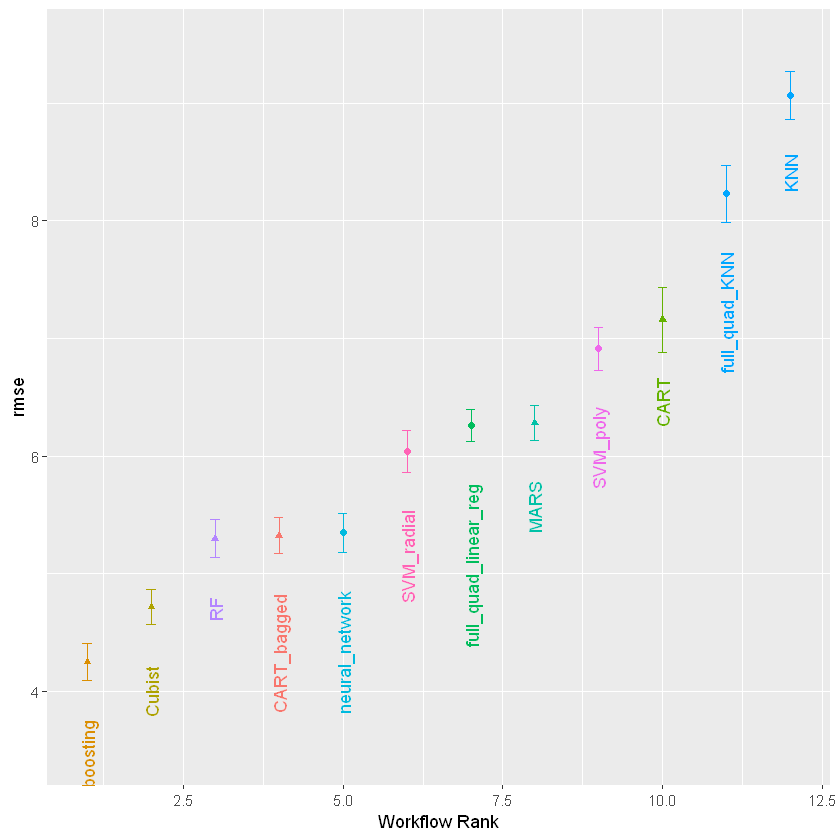

In [53]:
autoplot(
    grid_results,
    rank_metric = "rmse",  
    metric = "rmse",       
    select_best = TRUE    
) +geom_text(aes(y = mean - 1/2, label = wflow_id), angle = 90, hjust = 1) +
    lims(y = c(3.5, 9.5)) +
    theme(legend.position = "none")

<br>

#### 특정 모델의 파라미터 튜닝 결과 확인

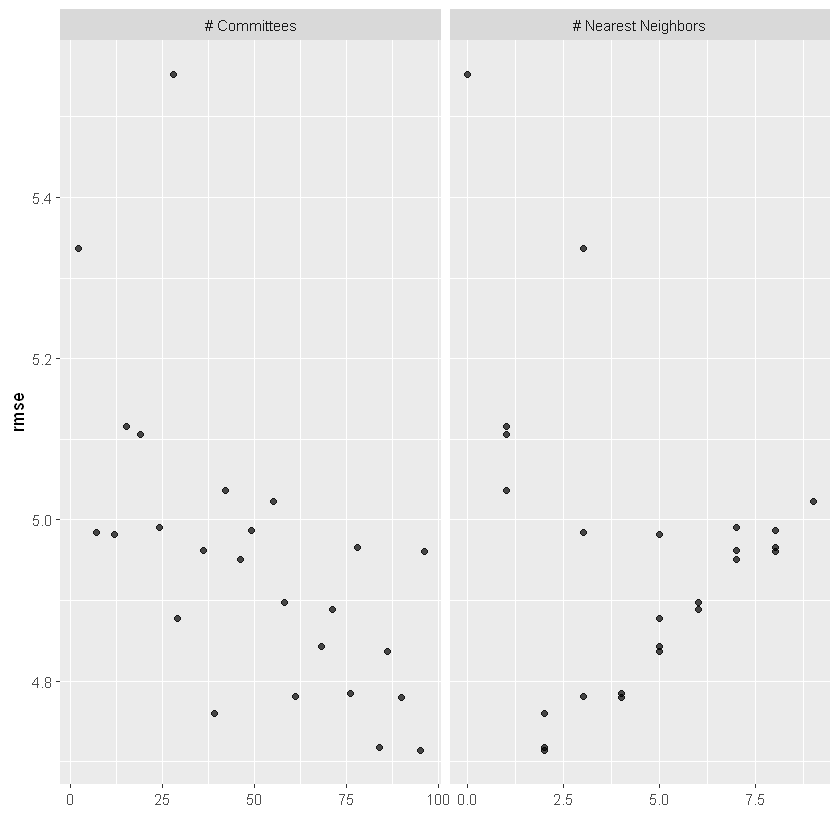

In [54]:
autoplot(grid_results, id = "Cubist", metric = "rmse")

<br>

## 12.04. 모델 선별
- **대규모 모델 워크플로 세트를 효율적으로 선별하는 방법은 Racing Method를 사용**

In [55]:
library(finetune)

In [56]:
race_ctrl <- control_race(
    verbose = FALSE,
    save_pred = TRUE,
    parallel_over = "everything",
    save_workflow = TRUE
)

In [57]:
race_results <- all_workflows %>%
    workflow_map(
        "tune_race_anova",
        seed = 1503,
        resamples = concrete_folds,
        grid = 25,
        control = race_ctrl
    )

In [59]:
rank_results(race_results, select_best = TRUE)

wflow_id,.config,.metric,mean,std_err,n,preprocessor,model,rank
<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<int>
boosting,Preprocessor1_Model16,rmse,4.1670180,0.091929052,50,workflow_variables,boost_tree,1
boosting,Preprocessor1_Model16,rsq,0.9358992,0.002827987,50,workflow_variables,boost_tree,1
Cubist,Preprocessor1_Model25,rmse,4.7137670,0.091306936,50,workflow_variables,cubist_rules,2
Cubist,Preprocessor1_Model25,rsq,0.9191041,0.002991308,50,workflow_variables,cubist_rules,2
RF,Preprocessor1_Model11,rmse,5.2341204,0.094169339,50,workflow_variables,rand_forest,3
RF,Preprocessor1_Model11,rsq,0.9043284,0.003196545,50,workflow_variables,rand_forest,3
CART_bagged,Preprocessor1_Model1,rmse,5.3244276,0.093477642,50,workflow_variables,bag_tree,4
CART_bagged,Preprocessor1_Model1,rsq,0.8983617,0.003354644,50,workflow_variables,bag_tree,4
neural_network,Preprocessor1_Model17,rmse,6.0634229,0.125719982,50,recipe,mlp,5


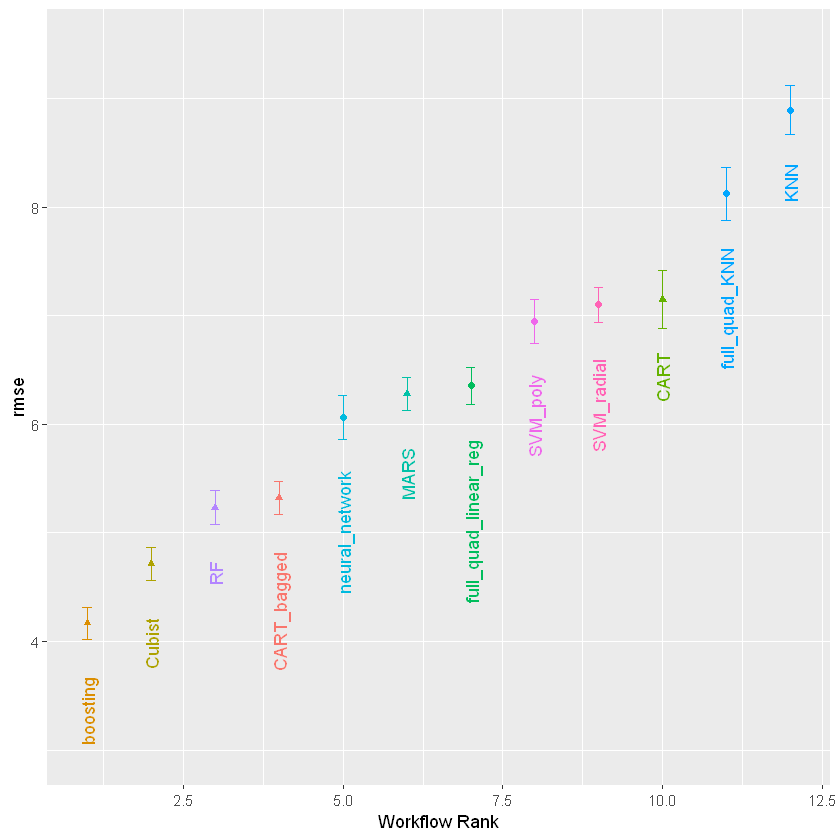

In [60]:
autoplot(
    race_results,
    rank_metric = "rmse",  
    metric = "rmse",       
    select_best = TRUE    
) + geom_text(aes(y = mean - 1/2, label = wflow_id), angle = 90, hjust = 1) +
    lims(y = c(3.0, 9.5)) +
    theme(legend.position = "none")

<br>

### 결과 병합
- 그리드 서치 결과와, Racing Method 결과 병합후, 모델별 성능 (RMSE) 시각화

In [61]:
library(ggrepel)

In [62]:
matched_results <- rank_results(race_results, select_best = TRUE) %>% 
    select(wflow_id, .metric, race = mean, config_race = .config) %>% 
    inner_join(
      rank_results(grid_results, select_best = TRUE) %>% 
         select(wflow_id, .metric, complete = mean, 
                config_complete = .config, model),
      by = c("wflow_id", ".metric"),
    ) %>%  
    filter(.metric == "rmse")

In [80]:
matched_results

wflow_id,.metric,race,config_race,complete,config_complete,model
<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
boosting,rmse,4.167018,Preprocessor1_Model16,4.248246,Preprocessor1_Model04,boost_tree
Cubist,rmse,4.713767,Preprocessor1_Model25,4.714210,Preprocessor1_Model24,cubist_rules
RF,rmse,5.234120,Preprocessor1_Model11,5.298662,Preprocessor1_Model18,rand_forest
CART_bagged,rmse,5.324428,Preprocessor1_Model1,5.324428,Preprocessor1_Model1,bag_tree
neural_network,rmse,6.063423,Preprocessor1_Model17,5.346236,Preprocessor1_Model23,mlp
MARS,rmse,6.280163,Preprocessor1_Model2,6.280163,Preprocessor1_Model2,mars
full_quad_linear_reg,rmse,6.354136,Preprocessor1_Model25,6.258668,Preprocessor1_Model16,linear_reg
SVM_poly,rmse,6.946846,Preprocessor1_Model18,6.911737,Preprocessor1_Model18,svm_poly
SVM_radial,rmse,7.100144,Preprocessor1_Model23,6.036471,Preprocessor1_Model01,svm_rbf


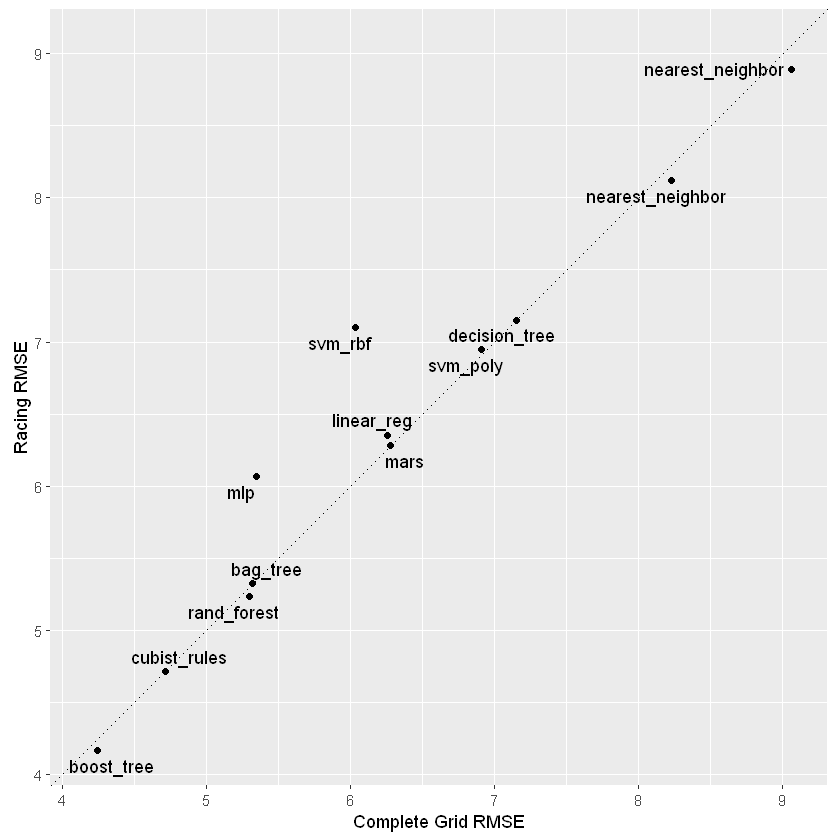

In [63]:
matched_results %>% 
    ggplot(aes(x = complete, y = race)) + 
    geom_abline(lty = 3) + 
    geom_point() + 
    geom_text_repel(aes(label = model)) +
    coord_obs_pred() + 
    labs(x = "Complete Grid RMSE", y = "Racing RMSE") 